## Setup

In [1]:
from IPython.display import display_html
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

import collections
import itertools
import re
import gc
import math
import numpy as np
import pandas as pd
import pickle
import requests as r
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import copy
import os

import typing
from typing import Mapping, Literal, Callable, List, ClassVar, Any, Tuple, Type

from uuid import uuid4
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, MACCSkeys, Draw
from rdkit.Chem.Draw import IPythonConsole
from datetime import date
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample, class_weight

pd.set_option('display.max_columns', 1000, 'display.width', 2000, 'display.max_colwidth', 100)

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import umap.plot

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\umap\distances.py:1086: Num

Setup directories:

In [2]:
data_dir = os.path.join(os.getcwd(), '..', 'data')
src_dir = os.path.join(os.getcwd(), '..', 'src')
fig_dir = os.path.join(data_dir, 'figures')
models_dir = os.path.join(os.getcwd(), '..', 'models')
dirs_to_make = [
    data_dir,
    os.path.join(data_dir, 'raw'),
    os.path.join(data_dir, 'processed'),
    os.path.join(data_dir, 'train'),
    os.path.join(data_dir, 'val'),
    os.path.join(data_dir, 'test'),
    src_dir,
    fig_dir,
    models_dir,
]
for d in dirs_to_make:
    if not os.path.exists(d):
        os.makedirs(d)

## Load Datasets

Setup global dictionary of dataframes:

In [3]:
dataframes = {}

ssl_df_path = os.path.join(data_dir, 'processed', 'protac_db_ssl.csv')
train_upsampled_df_path = os.path.join(data_dir, 'train', 'train_bin_upsampled.csv')
train_df_path = os.path.join(data_dir, 'train', 'train_bin.csv')
val_df_path = os.path.join(data_dir, 'val', 'val_bin.csv')
test_df_path = os.path.join(data_dir, 'test', 'test_bin.csv')
cols_to_keep = [
    'Smiles',
    'Smiles_nostereo',
    'DC50',
    'pDC50',
    'Dmax',
    'poi_gene_id',
    'poi_seq',
    'cell_type',
    'e3_ligase',
    'active',
]
# Assign train/val datasets for use in dataloaders
train_df_upsampled = pd.read_csv(train_upsampled_df_path).reset_index(drop=True)
train_df = pd.read_csv(train_df_path).reset_index(drop=True)
val_df = pd.read_csv(val_df_path).reset_index(drop=True)
test_df = pd.read_csv(test_df_path).reset_index(drop=True)
ssl_df = pd.read_csv(ssl_df_path).reset_index(drop=True)
dataframes['train_bin'] = train_df[cols_to_keep]
dataframes['train_bin_upsampled'] = train_df_upsampled[cols_to_keep]
dataframes['val_bin'] = val_df[cols_to_keep]
dataframes['test_bin'] = test_df[cols_to_keep]
dataframes['ssl_bin'] = ssl_df[cols_to_keep]

protac_df = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)
protac_df = protac_df[cols_to_keep]
protac_df.head()

,Smiles,Smiles_nostereo,DC50,pDC50,Dmax,poi_gene_id,poi_seq,cell_type,e3_ligase,active
0,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C...,5.600000e-07,6.251812,0.80,BRD9,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,HELA,VHL,False
1,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,1.760000e-09,8.754487,0.95,BRD9,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,RI-1,VHL,True
2,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,4.500000e-09,8.346787,0.95,BRD7,MGKKHKKHKSDKHLYEEYVEKPLKLVLKVGGNEVTELSTGSSGHDSSLFEDKNDHDKHKDRKRKKRKKGEKQIPGEEKGRKRRRVKEDKKKRDRDR...,RI-1,VHL,True
3,CCN(CCCCCOCC(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)N[C@@H](C)c1ccc(-c2scnc2C)cc1)C(C)(C)C)CCOc1c...,CCN(CCCCCOCC(=O)NC(C(=O)N1CC(O)CC1C(=O)NC(C)c1ccc(-c2scnc2C)cc1)C(C)(C)C)CCOc1ccc(C(=O)c2c(-c3cc...,1.700000e-10,9.769551,0.95,ER,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDSSKPAVYNYPEGAAYEFNAAAAANAQVYGQTGLPYGPGSEAAAFGSNGLGG...,MCF-7,VHL,True
4,CCN(CCCCCOCC(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)N[C@@H](C)c1ccc(-c2scnc2C)cc1)C(C)(C)C)CCOc1c...,CCN(CCCCCOCC(=O)NC(C(=O)N1CC(O)CC1C(=O)NC(C)c1ccc(-c2scnc2C)cc1)C(C)(C)C)CCOc1ccc(C(=O)c2c(-c3cc...,4.300000e-10,9.366532,0.95,ER,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDSSKPAVYNYPEGAAYEFNAAAAANAQVYGQTGLPYGPGSEAAAFGSNGLGG...,T47D,VHL,True


Load datasets:

## Dimensionality Reduction

### Get Fingerprints

In [ ]:
def get_fingerprint(smiles: str, n_bits: int = 1024, fp_type: Literal['morgan', 'maccs', 'path'] = 'morgan',
                    min_path: int = 1, max_path: int = 2,
                    atomic_radius: int = 2) -> np.ndarray:
    """Returns molecular fingerprint of a given molecule SMILES.

    Args:
        smiles (str): SMILES string to convert.
        n_bits (int, optional): Number of bits of the generated fingerprint. Defaults to 1024.
        fp_type (Literal[&#39;morgan&#39;, &#39;maccs&#39;, &#39;path&#39;], optional): Fingerprint type to generate. Defaults to 'morgan'.
        min_path (int, optional): Minimum path lenght for path-based fingerprints. Defaults to 1.
        max_path (int, optional): Maximum path lenght for path-based fingerprints. Defaults to 2.
        atomic_radius (int, optional): Atomic radius for MORGAN fingerprints. Defaults to 2.

    Raises:
        ValueError: When wrong fingerprint type is requested.

    Returns:
        np.ndarray: The generated fingerprint.
    """ 
    mol = Chem.MolFromSmiles(smiles)
    if fp_type == 'morgan':
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, atomic_radius,
                                                            nBits=n_bits)
    elif fp_type == 'maccs':
        fingerprint = MACCSkeys.GenMACCSKeys(mol)
    elif fp_type == 'path':
        fingerprint = Chem.rdmolops.RDKFingerprint(mol, fpSize=n_bits,
                                                   minPath=min_path,
                                                   maxPath=max_path)
    else:
        raise ValueError(f'Wrong type of fingerprint requested. Received "{fp_type}", expected one in: [morgan|maccs|path]')
    array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint, array)
    return array

### UMAP

Very insightful (and nicely visualized) explaination on how UMAP works can be found [here](https://pair-code.github.io/understanding-umap/).

TODOS:

* Color overlapping entries with different colors.
* Concatenate extra features as categorical to the fingerprints, then remove duplicates. Scale the obtain vectors. Finally run UMAP and plot the resulting embeddings. 

In [ ]:
train_bin_df = dataframes['train_bin'].copy()
val_bin_df = dataframes['val_bin'].copy()
test_bin_df = dataframes['test_bin'].copy()

train_bin_df['Dataset'] = 'Training'
val_bin_df['Dataset'] = 'Validation'
test_bin_df['Dataset'] = 'Test'

df = pd.concat([train_bin_df, val_bin_df, test_bin_df], ignore_index=True, axis=0)

C:\Users\ste\AppData\Local\Temp\ipykernel_18628\3312093965.py:9: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([train_bin_df, val_bin_df, test_bin_df], ignore_index=True, axis=0)


In [ ]:
if not os.path.exists(os.path.join(fig_dir, 'molecules')):
    os.makedirs(os.path.join(fig_dir, 'molecules'))

for smiles in df['Smiles_nostereo'].unique().tolist():
    filename = os.path.join(fig_dir, 'molecules', f'{smiles}.jpg')
    if not os.path.exists(filename):
        mol = Chem.MolFromSmiles(smiles)
        Chem.Draw.MolToImageFile(mol, filename, size=(300, 300))
df['img_paths'] = [os.path.join(fig_dir, 'molecules', f'{smiles}.jpg') for smiles in df['Smiles_nostereo'].tolist()]

In [ ]:
fp_bits = 2048
fp_type = 'morgan'
min_path = 1
max_path = 8
atomic_radius = 2

for fp_bits in [1024, 2048]:
    for atomic_radius in [3, 6, 8]:
        print(f'Generating {fp_bits}bit {fp_type} fingerprint with atomic radius {atomic_radius}...')
        args = (fp_bits, fp_type, min_path, max_path, atomic_radius)
        df[f'morgan_{fp_bits}bit_{atomic_radius}r'] = df['Smiles_nostereo'].apply(get_fingerprint, args=args)

print('Generating MACCS fingerprint...')
fp_type = 'maccs'
args = (fp_bits, fp_type, min_path, max_path, atomic_radius)
df['maccs'] = df['Smiles_nostereo'].apply(get_fingerprint, args=args)

Generating 1024bit morgan fingerprint with atomic radius 3...
Generating 1024bit morgan fingerprint with atomic radius 6...
Generating 1024bit morgan fingerprint with atomic radius 8...
Generating 2048bit morgan fingerprint with atomic radius 3...
Generating 2048bit morgan fingerprint with atomic radius 6...
Generating 2048bit morgan fingerprint with atomic radius 8...
Generating MACCS fingerprint...


In [ ]:
df = df.drop_duplicates(subset=['Smiles_nostereo'], keep='first')

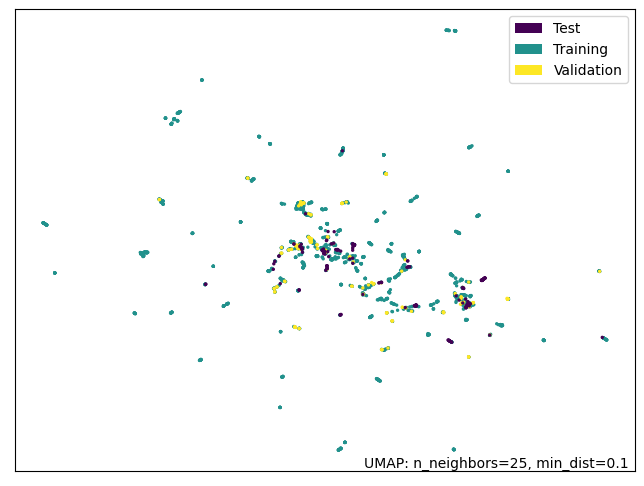

In [ ]:
umap_reducer = umap.UMAP(n_neighbors=25, min_dist=0.1, random_state=42)
# mapper = umap_reducer.fit(df['maccs'].tolist())
mapper = umap_reducer.fit(df['morgan_1024bit_8r'].tolist())
color_key = {
    'Training': 'C0',
    'Validation': 'C1',
    'Test': 'C2',
}
ax = umap.plot.points(mapper, labels=df['Dataset'], color_key_cmap='viridis', background='white', width=800, height=600)
plt.show()

The following interactive visualization code is based on this [blogpost](https://www.kaggle.com/code/btseytlin/interactive-visualization-with-umap-and-bokeh/notebook).

In [ ]:
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Category10

In [ ]:
TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="200" alt="@imgs" width="200"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <div style="font-size: 15px; font-weight: bold;">Dataset: @label</div>
            <div style="font-size: 12px;">Active: @active</div>
            <!-- <div style="font-size: 12px;">@desc</div> -->
            <div style="font-size: 12px; color: #966;">[$index]</div>
        </div>
    </div5
"""

source = ColumnDataSource(data=dict(
    x=mapper.embedding_[:, 0],
    y=mapper.embedding_[:, 1],
    label=df['Dataset'].tolist(),
    desc=df['Smiles_nostereo'].tolist(),
    imgs=df['img_paths'].tolist(),
    active=df['active'].astype(str).tolist(),
    # image_urls=image_urls,
))

p = figure(plot_width=1000, plot_height=600, tooltips=TOOLTIPS,
           title=f'UMAP: Mouse over the dots')

cmap = factor_cmap(field_name='label', palette=Category10[3], factors=['Training', 'Validation', 'Test'])

p.scatter('x', 'y',
          color=cmap,
          marker=factor_mark('active', ['circle', 'x'], [str(True), str(False)]),
          size=5,
          fill_alpha=0.5,
          legend_field='label', #'desc',
          source=source)

p.legend.orientation = 'vertical'
p.legend.location = 'top_right'
output_file(os.path.join(fig_dir, 'umap.html'))
show(p)

--------------------------------------------------------------------------------
n_neighbors: 25, min_dist: 0.1


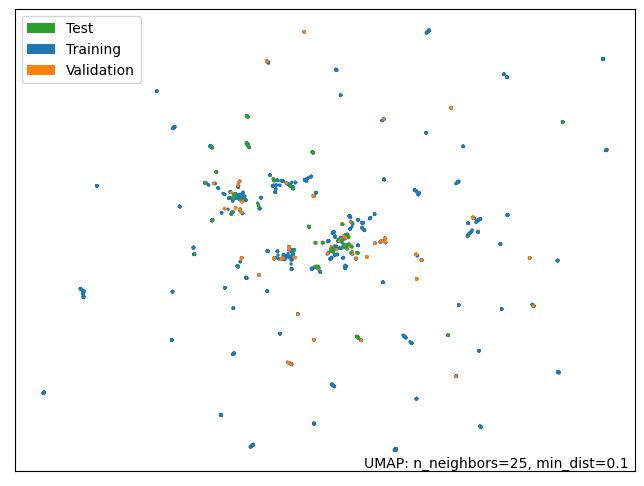

--------------------------------------------------------------------------------
n_neighbors: 25, min_dist: 0.2


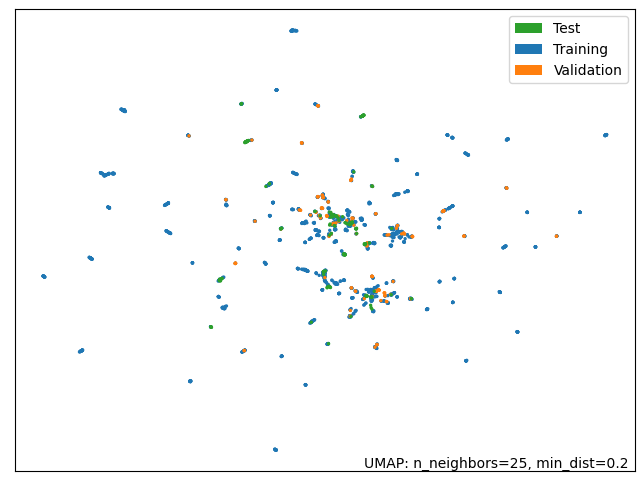

--------------------------------------------------------------------------------
n_neighbors: 25, min_dist: 0.30000000000000004


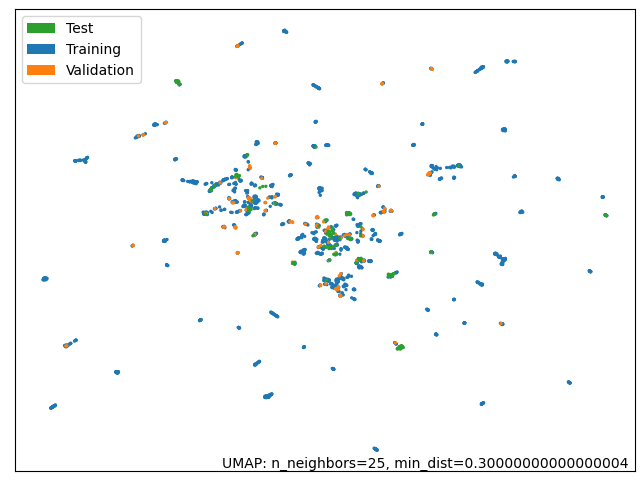

--------------------------------------------------------------------------------
n_neighbors: 25, min_dist: 0.4


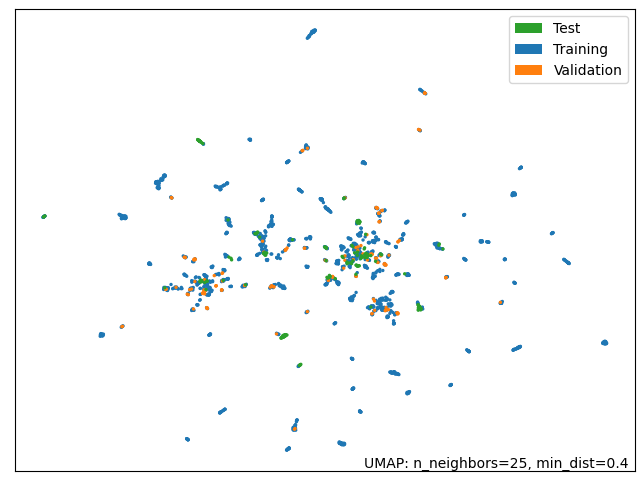

--------------------------------------------------------------------------------
n_neighbors: 50, min_dist: 0.1


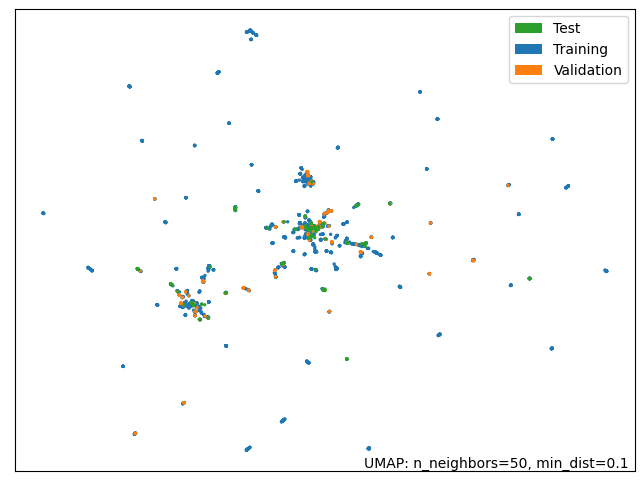

--------------------------------------------------------------------------------
n_neighbors: 50, min_dist: 0.2


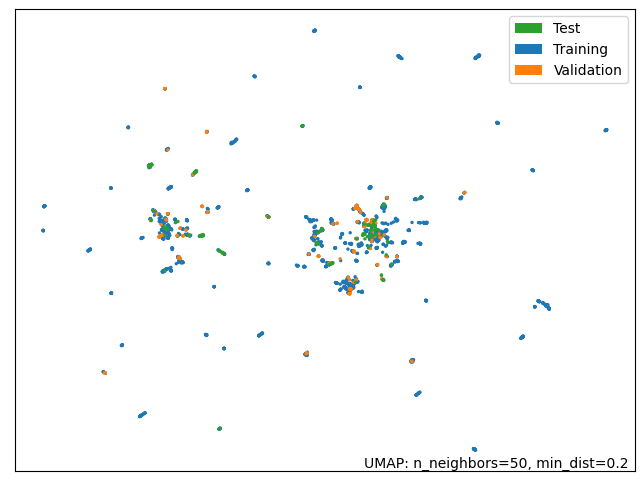

--------------------------------------------------------------------------------
n_neighbors: 50, min_dist: 0.30000000000000004


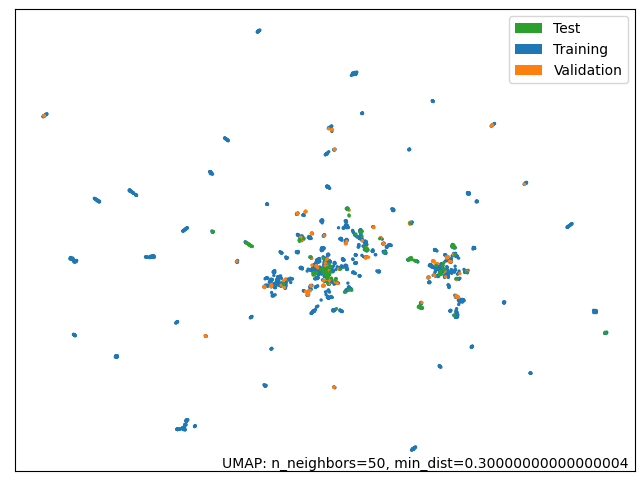

--------------------------------------------------------------------------------
n_neighbors: 50, min_dist: 0.4


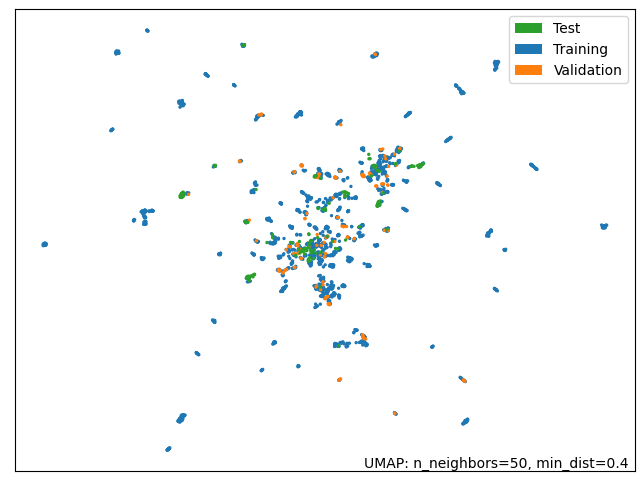

--------------------------------------------------------------------------------
n_neighbors: 75, min_dist: 0.1


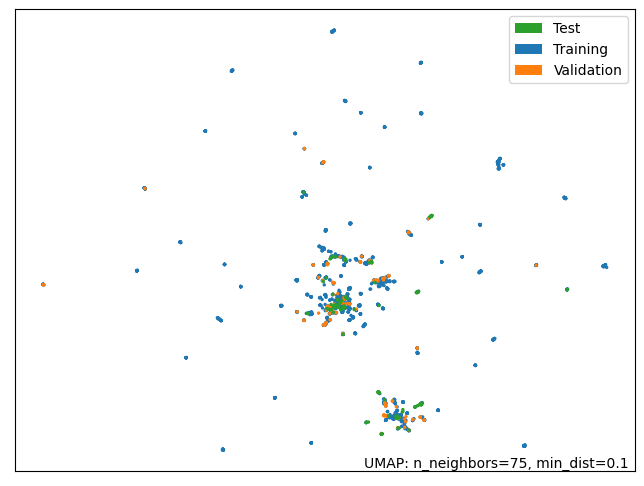

--------------------------------------------------------------------------------
n_neighbors: 75, min_dist: 0.2


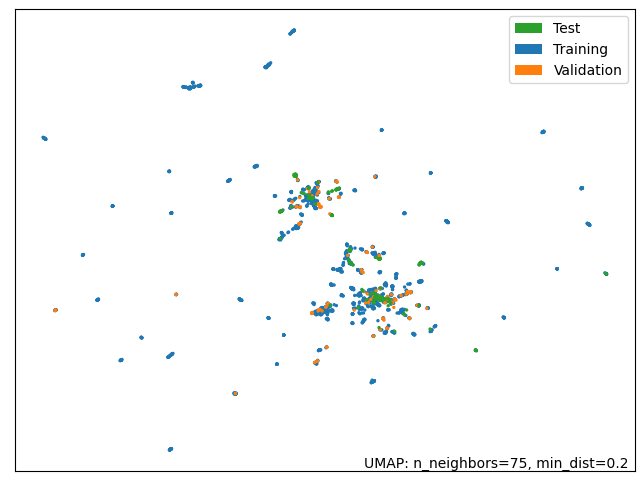

--------------------------------------------------------------------------------
n_neighbors: 75, min_dist: 0.30000000000000004


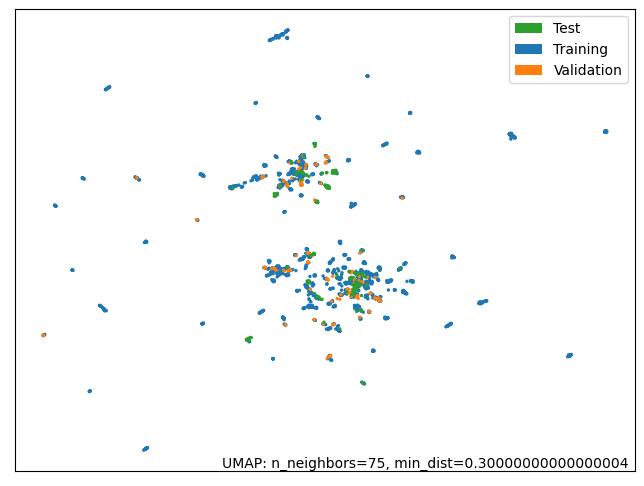

--------------------------------------------------------------------------------
n_neighbors: 75, min_dist: 0.4


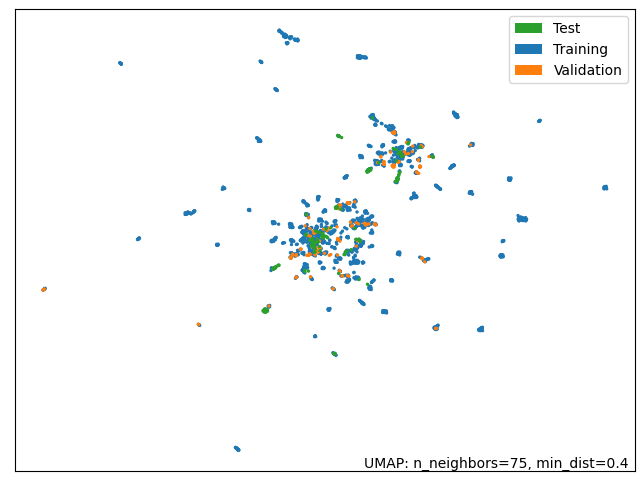

--------------------------------------------------------------------------------
n_neighbors: 100, min_dist: 0.1


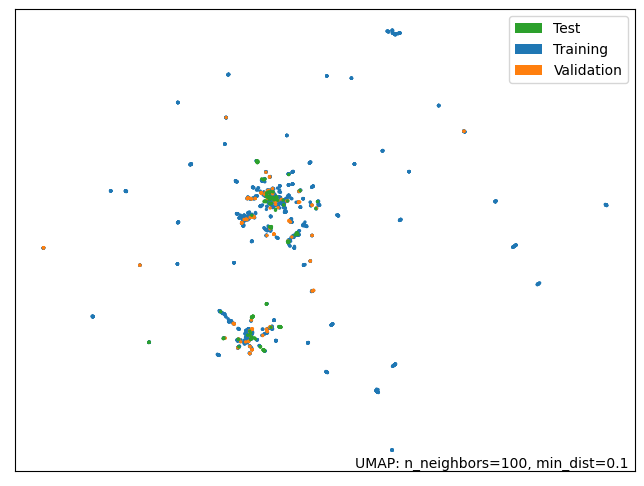

--------------------------------------------------------------------------------
n_neighbors: 100, min_dist: 0.2


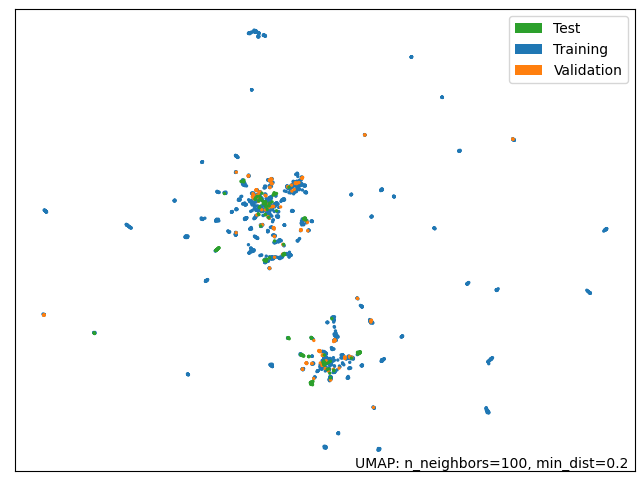

--------------------------------------------------------------------------------
n_neighbors: 100, min_dist: 0.30000000000000004


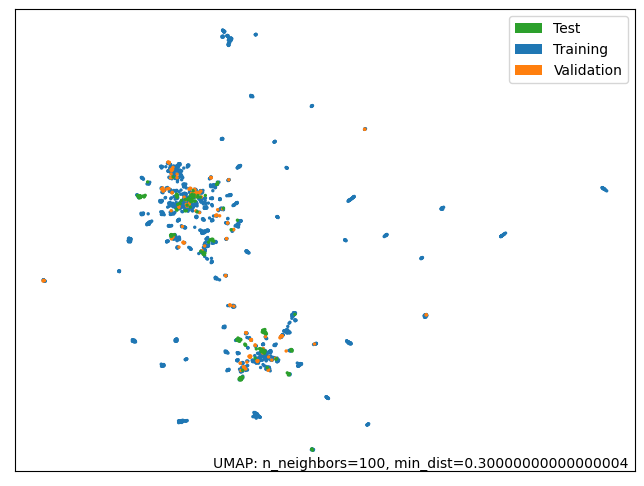

--------------------------------------------------------------------------------
n_neighbors: 100, min_dist: 0.4


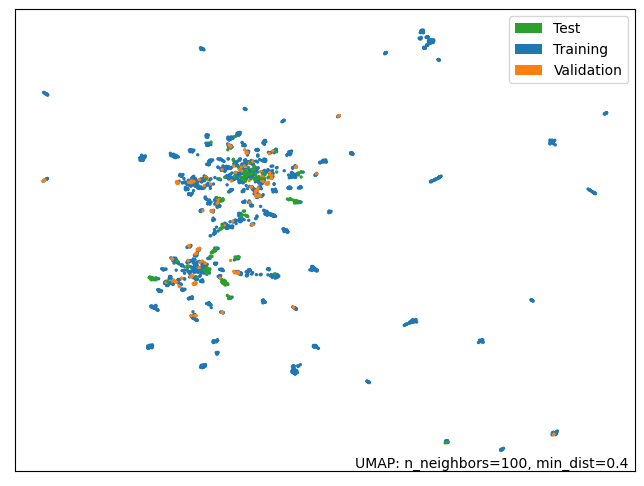

In [ ]:
n_neighbors = 50
min_dist = 0.1

# Plot different combinations of n_neighbors and min_dist
for n_neighbors in [25 * i for i in range(1, 5)]:
    for min_dist in [0.1 * j for j in range(1, 5)]:
        print('-' * 80)
        print(f'n_neighbors: {n_neighbors}, min_dist: {min_dist}')
        umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        mapper = umap_reducer.fit(df['FP'].tolist())
        color_key = {
            'Training': 'C0',
            'Validation': 'C1',
            'Test': 'C2',
        }
        ax = umap.plot.points(mapper, labels=df['Dataset'], color_key=color_key, background='white', width=800, height=600)
        plt.show()
        # ax.set_title(f'UMAP of the datasets')
# umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
# mapper = umap_reducer.fit(df['FP'].tolist())
# color_key = {
#     'Training': 'C0',
#     'Validation': 'C1',
#     'Test': 'C2',
# }
# ax = umap.plot.points(mapper, labels=df['Dataset'], color_key=color_key, background='white', width=800, height=600)
# # ax.set_title(f'UMAP of the datasets, {min_dist}')

In [ ]:
umap.plot.output_notebook()

Loading BokehJS ...

In [ ]:
p = umap.plot.interactive(mapper, labels=df['Dataset'], point_size=4, color_key_cmap='viridis', )
umap.plot.show(p)

[1] K. M. Sakamoto, K. B. Kim, A. Kumagai, F. Mercurio, C. M. Crews, and R. J. Deshaies, “Protacs: chimeric molecules that target proteins to the Skp1-Cullin-F box complex for ubiquitination and degradation,” Proc Natl Acad Sci U S A, vol. 98, no. 15, pp. 8554–8559, Jul. 2001, doi: 10.1073/pnas.141230798.

## BERT Embeddings

Plotting the UMAP embeddings of the BERT embeddings of the SMILES strings.

First, let's define a Lightning wrapper of a Transformer model:

In [4]:
from transformers import AutoConfig, AutoModelForSequenceClassification
import torch
import pytorch_lightning as pl

def mean_pooling(model_output, attention_mask):
    # First element of model_output contains all token embeddings
    token_embeddings = model_output['last_hidden_state']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


class TransformerSubModel(pl.LightningModule):

    def __init__(self, checkpoint_path: str = 'seyonec/ChemBERTa-zinc-base-v1'):
        super().__init__()
        # Save the arguments passed to init
        self.save_hyperparameters()
        self.__dict__.update(locals()) # Add arguments as attributes
        # ChemBERT for SMILES
        self.config = AutoConfig.from_pretrained(checkpoint_path,
                                                 output_hidden_states=True,
                                                 num_labels=1)
        self.chembert = AutoModelForSequenceClassification.from_pretrained(
            checkpoint_path,
            config=self.config
        ).roberta

    def forward(self, x_in):
        # Run ChemBert over the toeknized SMILES
        input_ids = x_in['smiles_tokenized']['input_ids'].squeeze(dim=1)
        attention_mask = x_in['smiles_tokenized']['attention_mask'].squeeze(dim=1)
        smiles_embedding = self.chembert(input_ids, attention_mask)
        # NOTE: Due to multi-head attention, the output of the Transformer is a
        # sequence of hidden states, one for each input token. The following
        # takes the mean of all token embeddings to get a single embedding.
        smiles_embedding = mean_pooling(smiles_embedding, attention_mask)
        return smiles_embedding
    
    def get_smiles_embedding_size(self):
        return self.config.to_dict()['hidden_size']

In [5]:
from datasets.protac_dataset import ProtacDataset
from torch.utils.data import DataLoader
from datasets.protac_dataloader import custom_collate
from transformers import RobertaTokenizerFast

protac_ds = ProtacDataset(protac_df,
                          smiles_tokenizer=os.path.join(models_dir, 'SSL_roberta_zinc_480m'),
                          smiles_tokenizer_type=RobertaTokenizerFast,
                          poi_seq_enc=os.path.join(models_dir, 'poi_encoder.joblib'),
                          e3_ligase_enc=os.path.join(models_dir, 'e3_ligase_encoder.joblib'),
                          cell_type_enc=os.path.join(models_dir, 'cell_type_encoder.joblib'))
protac_dl = DataLoader(protac_ds,
                       batch_size=16,
                       shuffle=False,
                       collate_fn=custom_collate)

In [6]:
encoder = TransformerSubModel(os.path.join(models_dir, 'SSL_roberta_zinc_480m'))
if torch.cuda.is_available():
    encoder.cuda()

Some weights of the model checkpoint at c:\Users\ste\master\thesis\Machine-Learning-for-Predicting-Targeted-Protein-Degradation\notebooks\..\models\SSL_roberta_zinc_480m were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at c:\Users\ste\master\thesis\Machine-Learning-for

In [8]:
from tqdm import tqdm
import numpy as np

def to_cuda(batch):
    tmp = {}
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            tmp[k] = v.cuda()
        else:
            tmp[k] = to_cuda(v)
    return tmp

smiles_embeddings = []
for batch in tqdm(protac_dl):
    if torch.cuda.is_available():
        batch = to_cuda(batch)
    smiles_embeddings.append(encoder(batch).detach().cpu().numpy())
smiles_embeddings = np.vstack(smiles_embeddings)
print(smiles_embeddings.shape)

100%|██████████| 306/306 [00:59<00:00,  5.18it/s]


ValueError: all input arrays must have the same shape

Finally, plot the UMAP-ped SMILES embeddings:

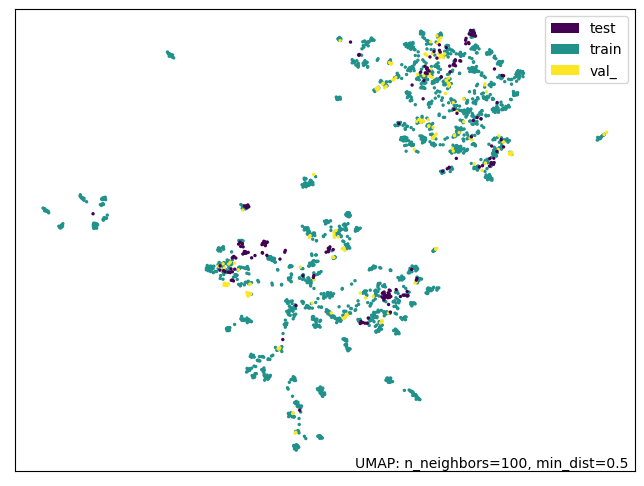

In [22]:
umap_reducer = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=42)
mapper = umap_reducer.fit(smiles_embeddings)
labels = ['train'] * len(train_df) + ['val_'] * len(val_df) + ['test'] * len(test_df)
labels = np.array(labels)
color_key = {
    'Training': 'C0',
    'Validation': 'C1',
    'Test': 'C2',
}
ax = umap.plot.points(mapper, labels=labels, color_key_cmap='viridis', background='white', width=800, height=600)
plt.show()

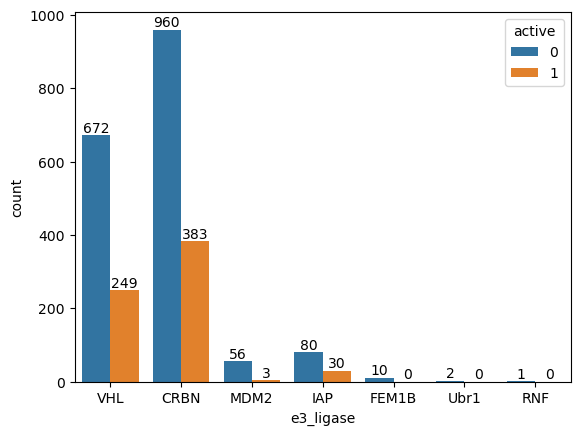

In [46]:
labels = ['train'] * len(train_df) + ['val'] * len(val_df) + ['test'] * len(test_df)
labels = np.array(labels)
protac_df['Dataset'] = labels
protac_df['E3 classes'] = protac_ds.e3_ligase
ax = sns.countplot(data=protac_df, x='e3_ligase', hue='Dataset')
for bars_group in ax.containers:
    ax.bar_label(bars_group) # fontsize=12

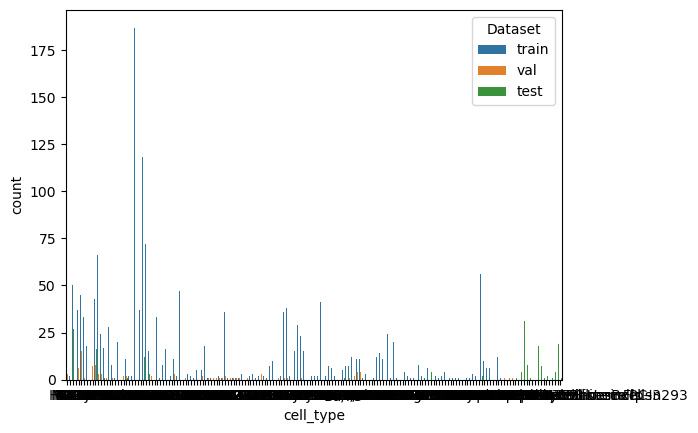

In [48]:
labels = ['train'] * len(train_df) + ['val'] * len(val_df) + ['test'] * len(test_df)
labels = np.array(labels)
protac_df['Dataset'] = labels
ax = sns.countplot(data=protac_df, x='cell_type', hue='Dataset')
# for bars_group in ax.containers:
#     ax.bar_label(bars_group) # fontsize=12

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


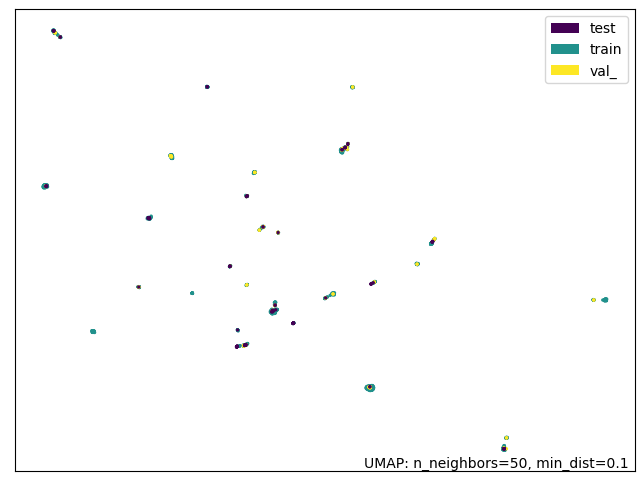

In [29]:
umap_reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, random_state=42)
mapper = umap_reducer.fit(protac_ds.poi_seq_enc.transform(protac_df['poi_seq'].tolist()))
color_key = {
    'Training': 'C0',
    'Validation': 'C1',
    'Test': 'C2',
}
ax = umap.plot.points(mapper, labels=labels, color_key_cmap='viridis', background='white', width=800, height=600)
plt.show()